1. cell type 
2. coarse cell type

check elbo between wrong and correct ones

In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

In [3]:
from scipy.stats import spearmanr, norminvgauss, invgauss, expon
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import copy

In [4]:
import numpy.ma as ma

def plot_cor(A,B):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = A[msk]
    Y = B[msk]
    plt.loglog(A[msk],A[msk],'k')
    plt.plot(A[msk],B[msk],'.', \
           label="CCC="+str(np.round(CCC(X,Y),2))\
             +"\nPearson's r="+str(np.round(np.corrcoef(X,Y)[0,1],2)));
    plt.legend(fontsize=15)

# EDA

## Load counts

h5 files can be downloaded as following:
```
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_for_velocity_mouse.h5
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_human_for_velocity.h5
```

In [5]:
adata = sc.read('./data/erythroid_lineage.h5ad')
gene_names = adata.var_names
x = adata.obsm['X_pca']
x[:,0] *= -1
adata

AnnData object with n_obs × n_vars = 9815 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

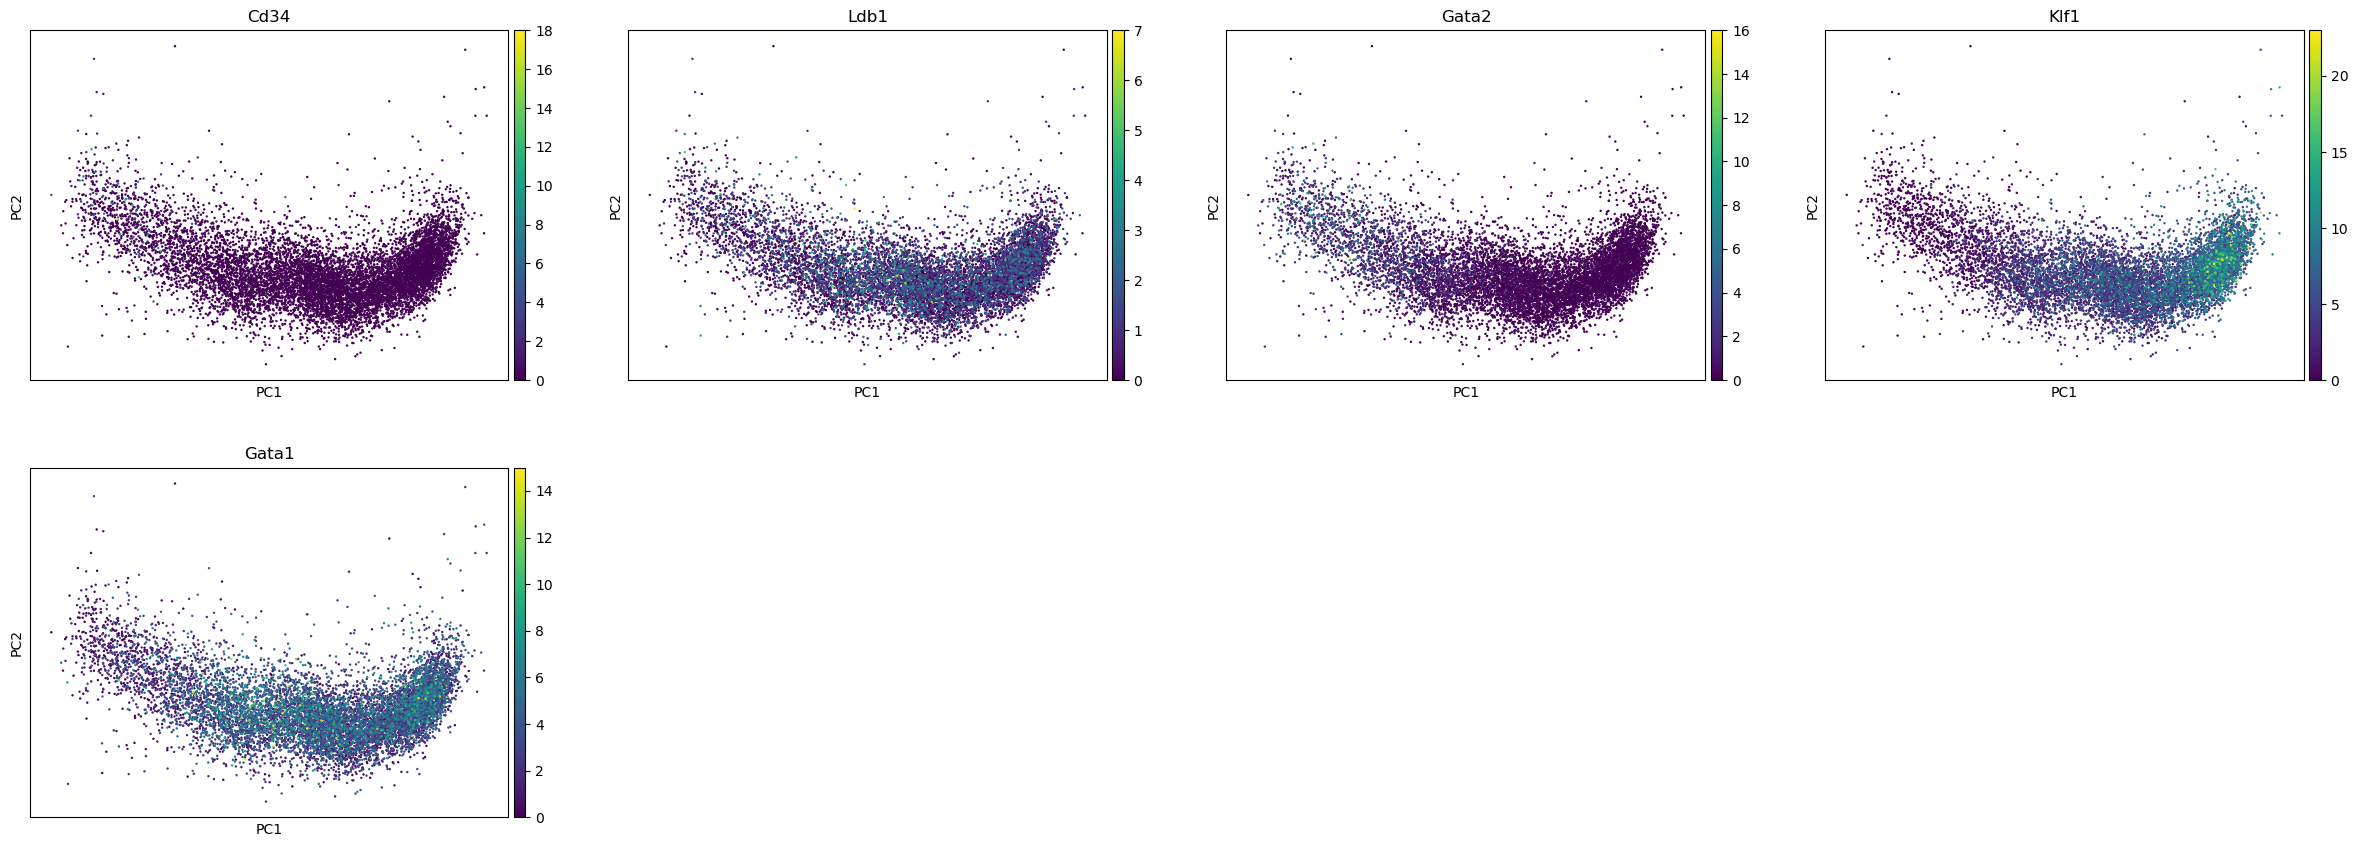

In [6]:
plot_marker_genes = ['Cd34','Gata1','Klf1','Gata2','Ldb1']
# Spn==Cd43
sc.pl.pca(adata,color=adata.var_names[adata.var_names.isin(plot_marker_genes)])

In [7]:
clusters = adata.obs["celltype"]
Clusters = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", adata.uns['celltype_colors'], N=5)

In [8]:
cell_types = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']

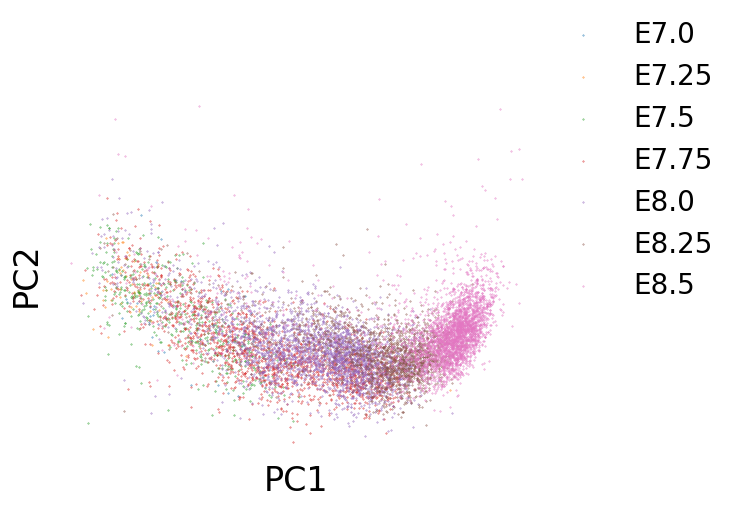

In [9]:
fig, ax = plt.subplots(1,1)
for i,stage in enumerate(stages):
    idx = adata.obs['stage'].isin([stage])
    im=ax.scatter(x[idx,0],x[idx,1],s=0.1,label=stage);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
ax.legend(loc=(1,0.4),fontsize=20,frameon=False)
ax.set_xlabel('PC1',fontsize=24)
plt.xticks([]);
plt.yticks([]);

Blood progenitors 1 623
Blood progenitors 2 2460
Erythroid1 2929
Erythroid2 1106
Erythroid3 2697


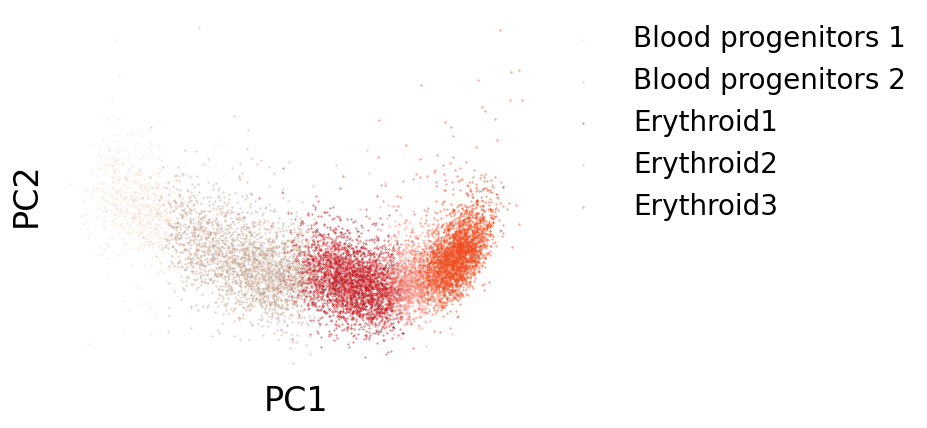

In [10]:
fig, ax = plt.subplots(1,1)
for i,cell_type in enumerate(cell_types):
    idx = adata.obs['celltype'].isin([cell_type])
    print(cell_type,idx.sum())
    im=ax.scatter(x[idx,0],x[idx,1],c=adata.uns['celltype_colors'][i],s=0.1,label=cell_type);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
ax.legend(loc=(1,0.4),fontsize=20,frameon=False)
ax.set_xlabel('PC1',fontsize=24)
plt.xticks([]);
plt.yticks([]);

## Gene variance

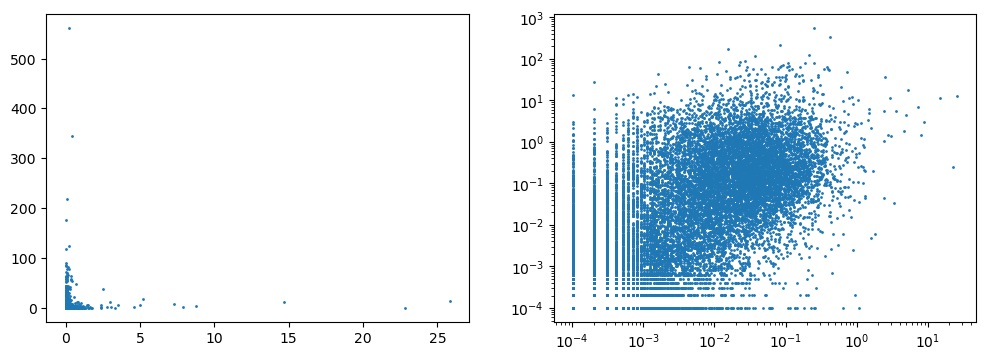

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [14]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.2885614206669618
s estimated by normalized covariance of total S counts = 0.31410537378009695
s estimated by normalized covariance of total counts = 0.29994463065178745
s estimated by total counts = 0.11182940885378902


s estimated by normalized covariance of Poission genes = 0.11182940885378902


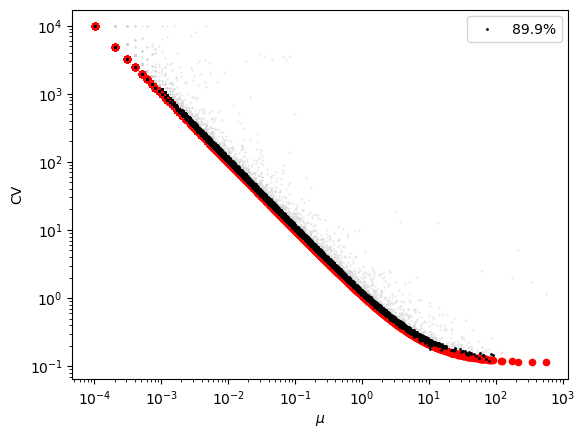

In [15]:
a=1
s=s2

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)

Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.2)
idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
#P_cov = np.cov(P,rowvar=False)
#P_mean = np.mean(P,axis=0)
#P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
#s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar, a/X_bar + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

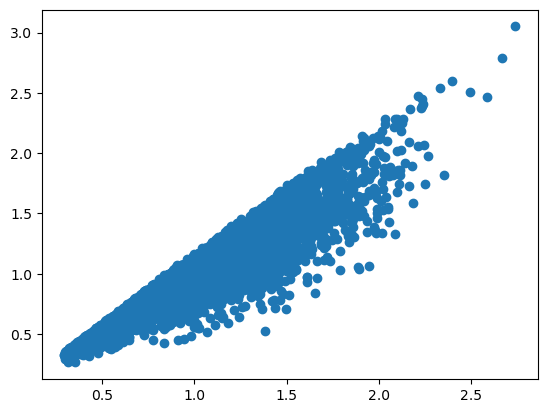

In [16]:
read_depth =  (U + S).sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,(U + S)[:,Pgene_mask].mean(1)/(U + S)[:,Pgene_mask].mean())

## Select genes

In [17]:
var_threshold = 1.2
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.1) \
    & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)
fitted_genes=adata.var_names[fitted_idx]
len(fitted_genes)

/tmp/ipykernel_3272105/2024459559.py:7: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
/tmp/ipykernel_3272105/2024459559.py:8: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold) \
/tmp/ipykernel_3272105/2024459559.py:9: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_3272105/2024459559.py:9: RuntimeWarning: invalid value encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_3272105/2024459559.py:9: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4)


30

In [18]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

27

27


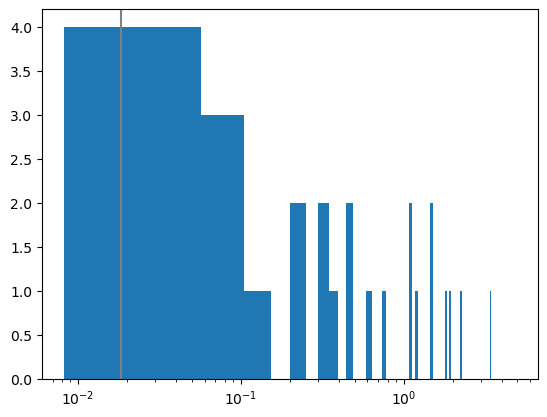

In [19]:
gene_length_file = np.loadtxt("data/gg_200524_mouse_genome_polyA_cum_1.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0] for gene in gene_length_file])

fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(len(fitted_genes))

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

In [20]:
idx1 = np.where(gene_name == 'Hba-x')[0][0]
idx2 = np.where(adata.var_names == 'Hba-x')[0][0]

adata.layers["unspliced"][:,idx2].mean()/adata.layers["spliced"][:,idx2].mean()/(10**(-5)*gene_length[idx1])

0.0709651461674956

/tmp/ipykernel_3272105/2237496637.py:2: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(S_mean, a/S_mean + s2, c='r', s=20)
/tmp/ipykernel_3272105/2237496637.py:3: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
/tmp/ipykernel_3272105/2237496637.py:8: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(U_mean, a/U_mean + s2, c='r', s=20)
/tmp/ipykernel_3272105/2237496637.py:9: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)


(9815, 27, 2)

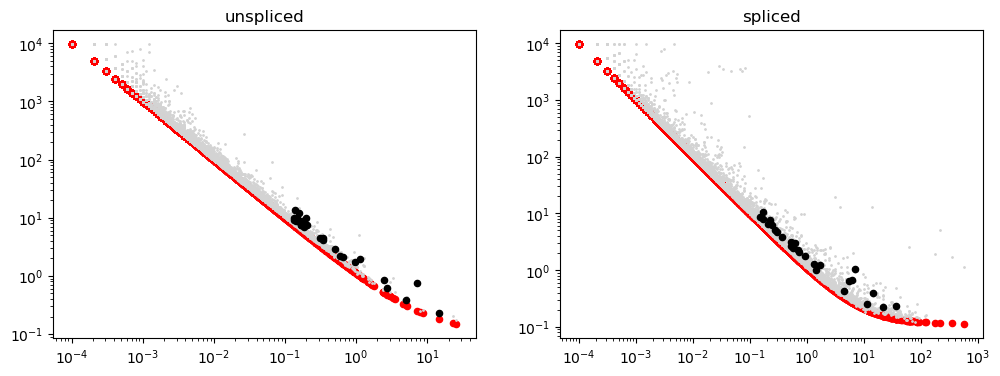

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[1].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[1].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('spliced')
ax[0].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[0].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('unspliced')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

In [23]:
marker_genes = ['Smim1','Hba-x','Abcg2','Cnn3','Scube2','Klf1','Gata2','Gata2','Cd45']
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Smim1', 'Abcg2', 'Cnn3'], dtype='object', name='index')


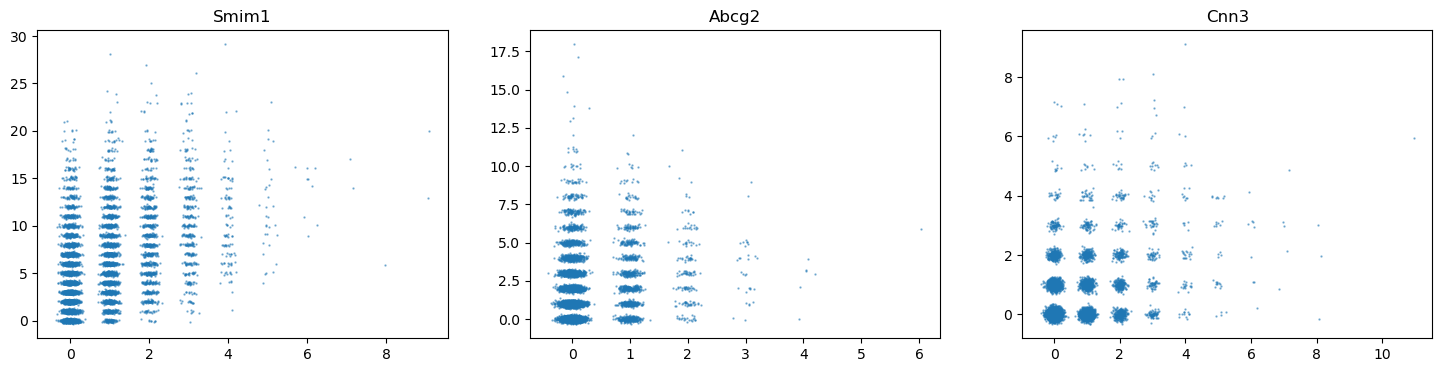

In [24]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

## Mixtures fitting

In [25]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

1 -75.7181740794357 -75.72367586242092 -75.74345935828248
2 -70.13387590256106 -70.1449813534016 -70.18491470615919
3 -68.52538623765659 -68.54209535635246 -68.60217856600609
4 -67.44432230422034 -67.46663509077153 -67.54686815732119
5 -66.89781610146781 -66.92573255587433 -67.02611547932001
6 -66.64338737209042 -66.67690749435226 -66.79744027469397


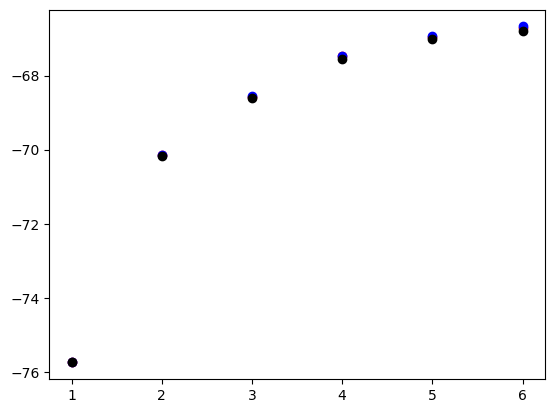

In [26]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X_mix),color='b')
    plt.scatter(nc,PM.compute_BIC(X_mix),color='k')
    print(nc,PM.compute_lower_bound(X_mix),PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

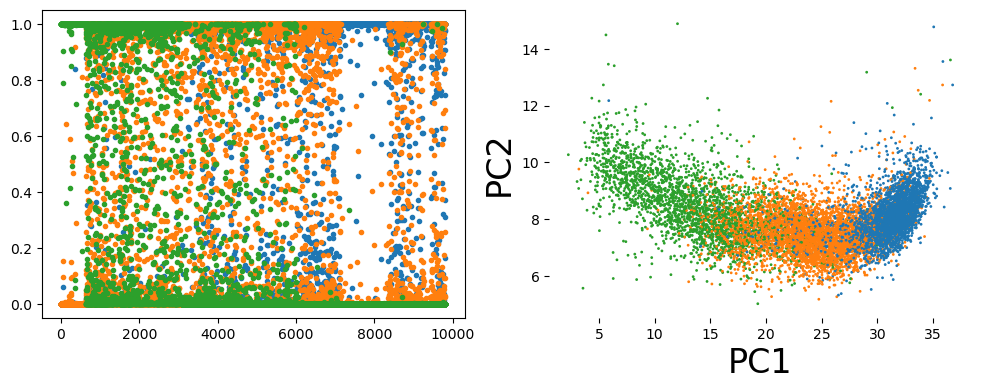

In [27]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=-1)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

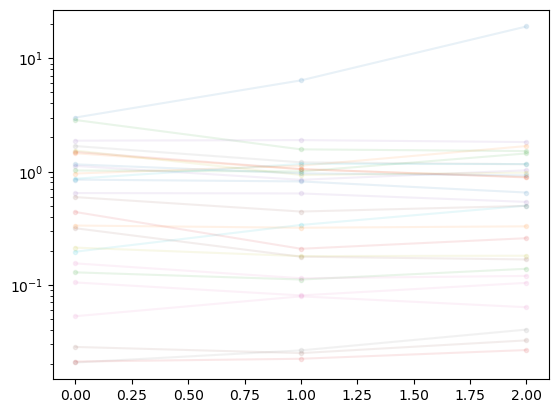

In [28]:
gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

## Filter genes

In [29]:
weird_idx = np.where(gbr.max(0)/gbr.min(0)>10)[0]
fitted_genes[weird_idx]

Index([], dtype='object', name='index')

In [30]:
"""
constant_idx = np.where(gbr.max(0)/gbr.min(0)<2)[0]

fitted_genes = fitted_genes[constant_idx]
fitted_idx = adata.var_names.isin(fitted_genes)

X = X[:,constant_idx]
Ub = Ub[constant_idx]
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])
X.shape
"""

'\nconstant_idx = np.where(gbr.max(0)/gbr.min(0)<2)[0]\n\nfitted_genes = fitted_genes[constant_idx]\nfitted_idx = adata.var_names.isin(fitted_genes)\n\nX = X[:,constant_idx]\nUb = Ub[constant_idx]\nplot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]\nplot_idx = np.concatenate(plot_idx).ravel()\nprint(fitted_genes[plot_idx])\nX.shape\n'

-68.45608602042178


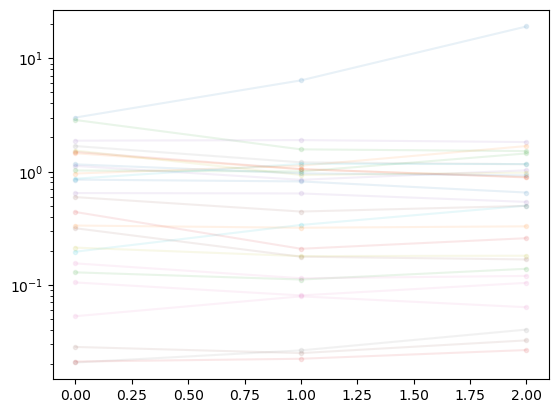

In [31]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
print(elbo)

gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

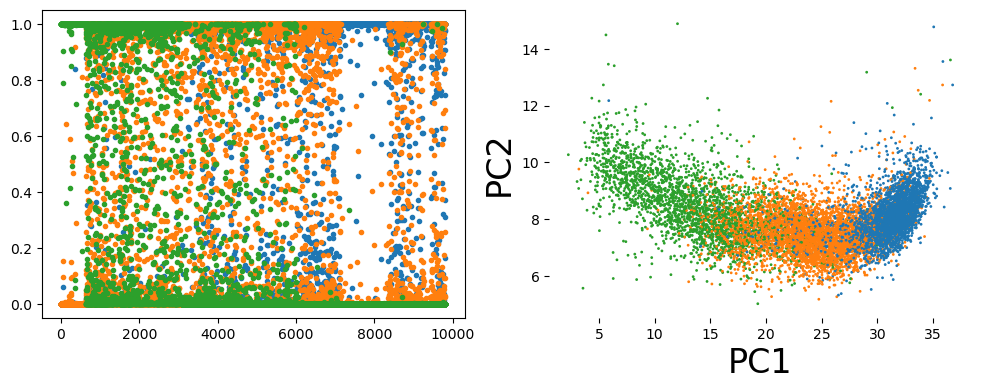

In [32]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.argmax(Q,axis=-1)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

# Trajectory fitting

In [33]:
elbos = {}
params_Ub={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_a":0}
params={'r':rd,"lambda_tau":0,"lambda_a":0}

topo = np.array([[0,1,2]])
tau = (0,1,2) # ~48 hours

## Clusters

fitting with warm start


0it [00:00, ?it/s]

-70.11597710448889



/home/mffang/workspace/Poisson-regression/RADOM/inference.py:162: RuntimeWarning: divide by zero encountered in log
  logL += np.log(self.weights)


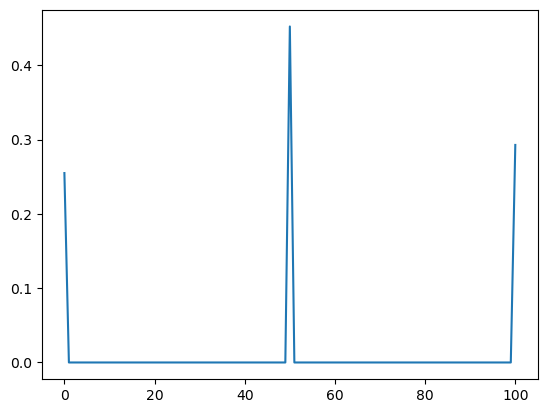

In [34]:
cluster_prior = np.zeros(101)
cluster_prior[100], cluster_prior[50], cluster_prior[0] = PM.weights
plt.plot(cluster_prior)

theta = np.zeros((X.shape[1],5))
theta[:,:3] = np.transpose(PM.theta[:,:,0].copy())[:,[2,1,0]]
theta[:,-2] = 10000
theta[:,-1] = theta[:,-2]*gbr.mean(0)

traj_cluster = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_cluster = traj_cluster.fit(X,warm_start=True,fit_tau=False,prior=cluster_prior,params=params,theta=theta,parallel=True,n_threads=4,epoch=0)
print(traj_cluster.elbos[-1])

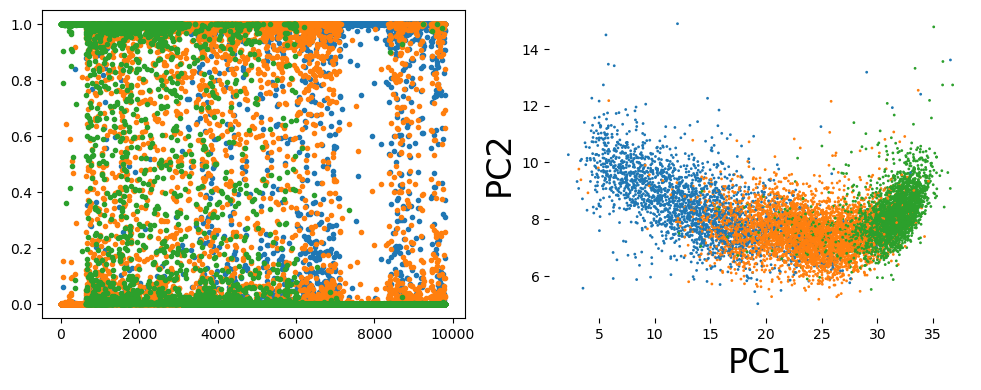

In [35]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=tab_colors[np.array(np.argmax(traj_cluster.Q,axis=-1)/50,dtype=int)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

## Fine cluster

In [36]:
m=201
weight0 = np.ones((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0 = weight0/weight0.sum(axis=1,keepdims=True)
Q0 = weight0[:,None]

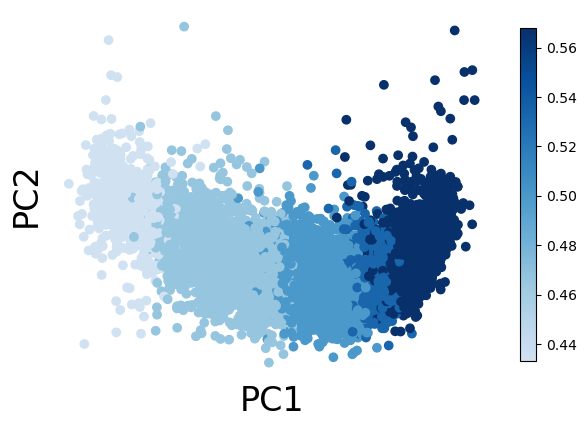

In [37]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=weight0@(np.linspace(0,1,m).reshape((-1,1))),cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [38]:
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=100)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]

-71.44745205948004


In [39]:
traj_Ub = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_Ub = traj_Ub.fit(X,warm_start=True,fit_tau=True,params=params_Ub,Q=Q0,parallel=True,n_threads=4,epoch=100)
print(traj_Ub.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

-71.91283737539551


In [40]:
traj_r = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_r = traj_r.fit(X,warm_start=True,fit_tau=True,params=params,Q=np.flip(Q0,axis=-1),parallel=True,n_threads=4,epoch=100)
print(traj_r.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [02:05<00:00,  1.26s/it]

-71.95240389297282


[0.         1.22263527 2.        ]


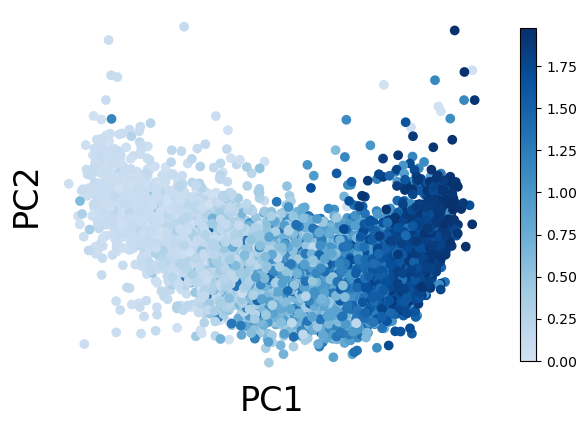

In [41]:
print(traj.tau)
t_hat = traj.Q.sum(1)@traj.t
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

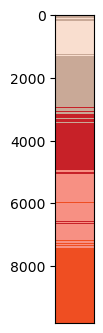

In [42]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,cell_type in enumerate(cell_types):
    idx = adata.obs["celltype"].isin([cell_type])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

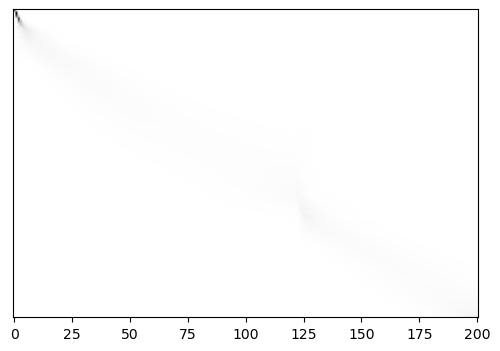

In [43]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

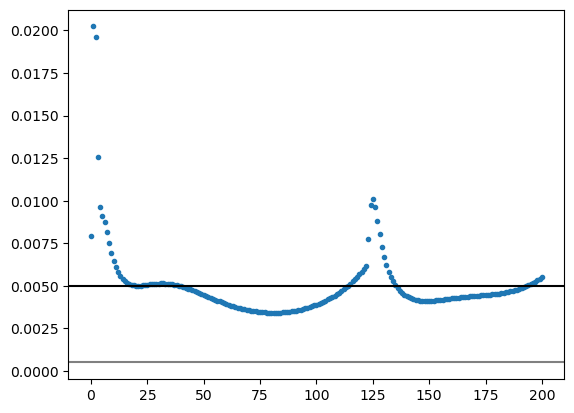

In [44]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

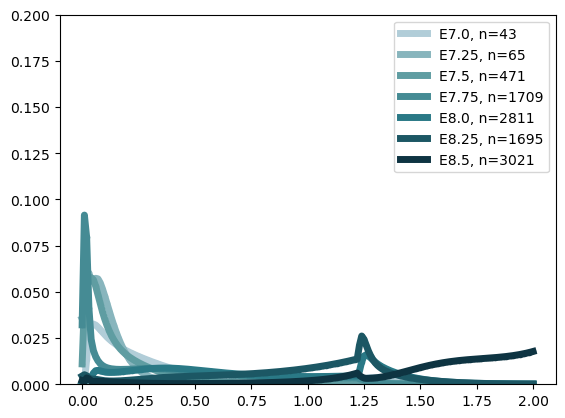

In [45]:
Timepoints = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']

#color_palette_blue = ["#b3cde0","#6497b1","#005b96","#011f4b"]
#color_palette = ["#daf8e3","#97ebdb","#00c2c7","#0086ad","#005582"]
#color_palette = ["#006666","#008080","#66b2b2","#b2d8d8"]
color_palette = ["#b1cdd8","#5f9da2","#2a7986","#0e3442"]

from matplotlib.colors import LinearSegmentedColormap
timepoint_cmp = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Timepoints))

for i,timepoint in enumerate(Timepoints):
    idx = adata.obs["stage"].isin([timepoint])
    plt.plot(traj.t,traj.Q[idx,0].mean(0),'.-',linewidth=5,label=timepoint+", n="+str(idx.sum()),color=timepoint_cmp(i))
plt.ylim((0,0.2))
plt.legend();

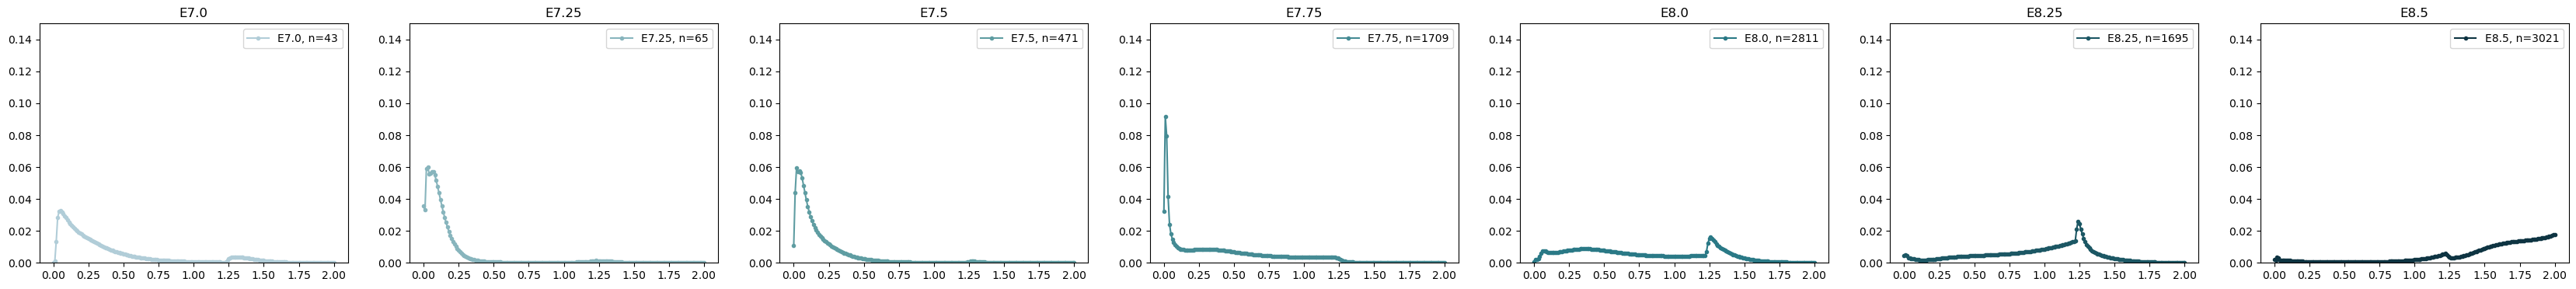

In [46]:
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']
fig, ax = plt.subplots(1,len(stages),figsize=(6*len(stages),4))
for i,stage in enumerate(stages):
    idx = adata.obs["stage"].isin([stage])
    ax[i].plot(traj.t,traj.Q[idx,0].mean(0),'.-',label=stage+", n="+str(idx.sum()),color=timepoint_cmp(i))
    ax[i].set_title(stage)
    ax[i].set_ylim((0,0.15))
    ax[i].legend()

0.11190293417046726
0.48864498788430333 1.4825785016608222


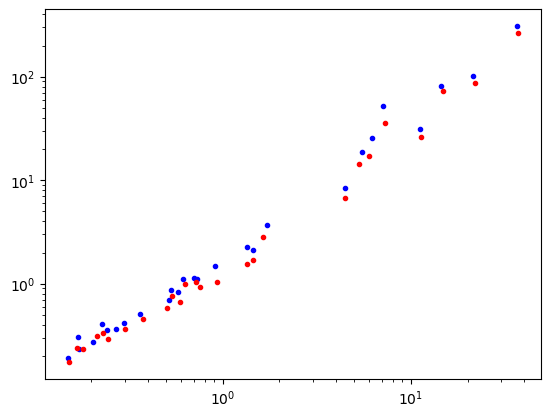

In [47]:
Y = traj.get_Y_hat(traj.theta, t_hat, traj.tau, traj.topo, traj.params)[0]
rd_s = traj.params['r'].var()/traj.params['r'].mean()**2
print(rd_s)
mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)
plt.loglog(mean,var,'b.')
plt.loglog(Y_mean,rd_s*mean**2+mean+(1+rd_s)*Y_var,'r.')
signal = Y_var
noise = var-rd_s*mean**2-(1+rd_s)*Y_var
unexplained = noise - mean
print((signal/mean).mean(),(noise/mean).mean())

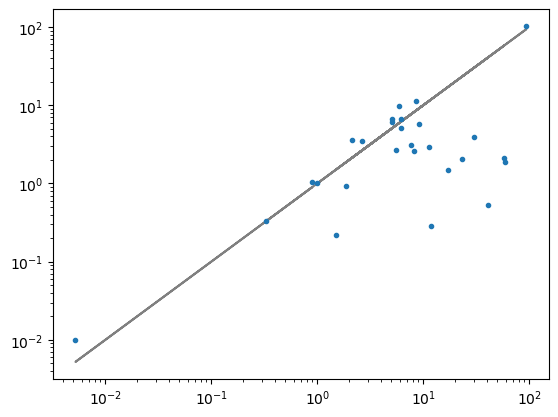

In [48]:
plt.loglog(traj.theta[:,[-2]],traj.theta[:,[-2]],'-',color='gray');
plt.loglog(traj.theta[:,[-2]],traj.theta[:,[-1]],'.');

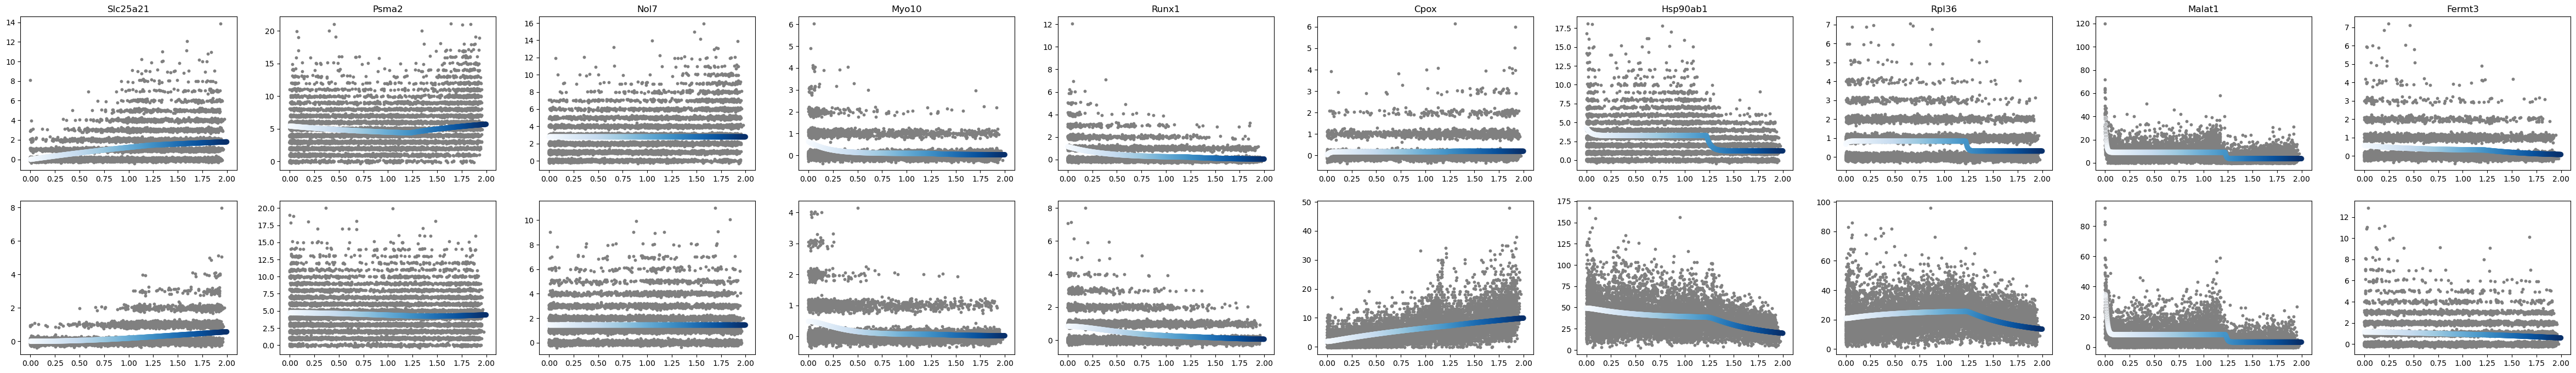

In [51]:
plot_y(traj,X=X,idx=np.arange(10),gene_name=fitted_genes);

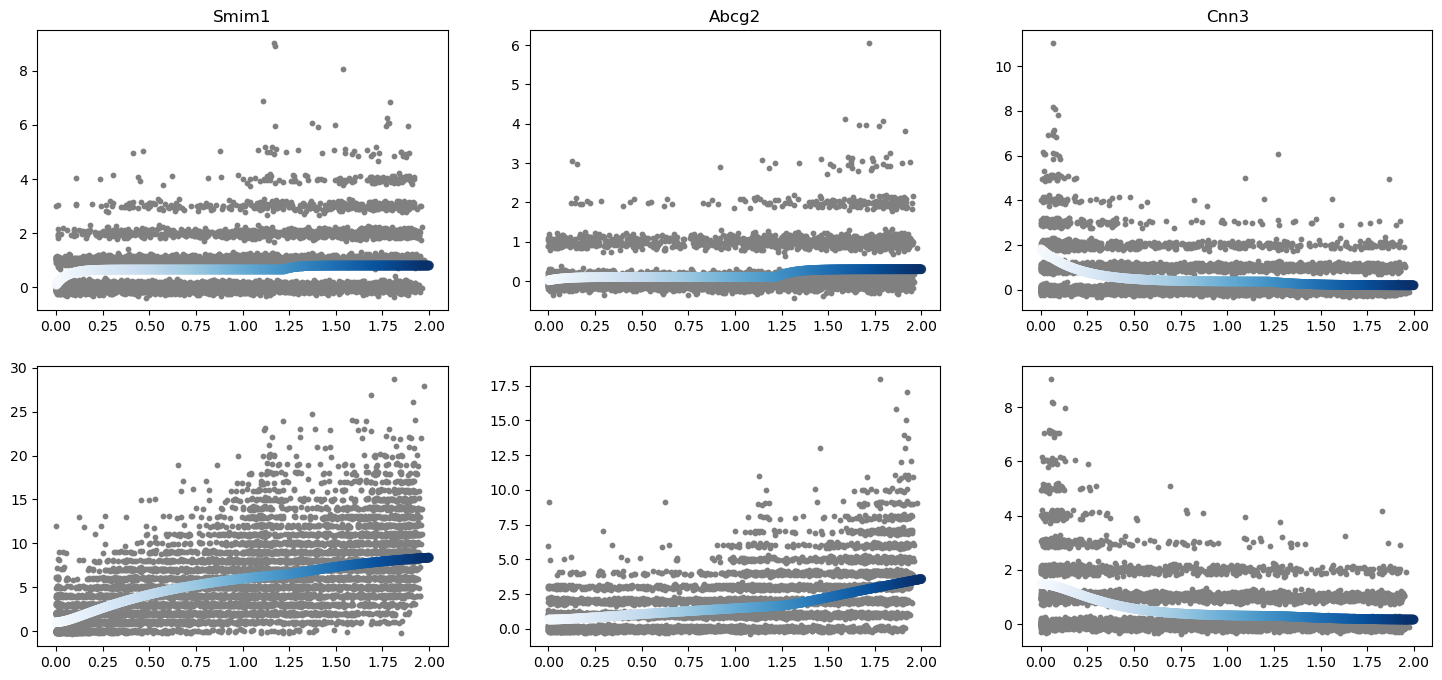

In [52]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

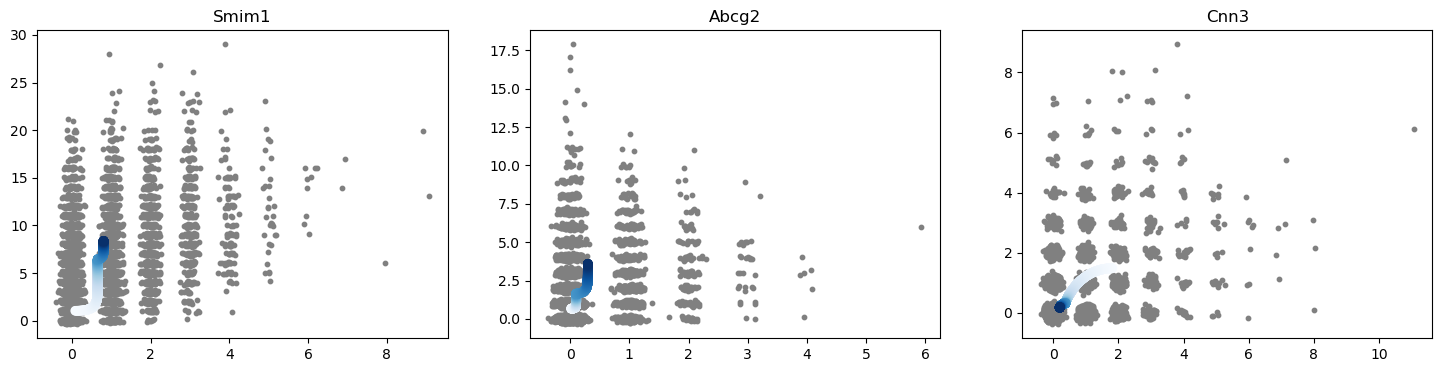

In [53]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

2


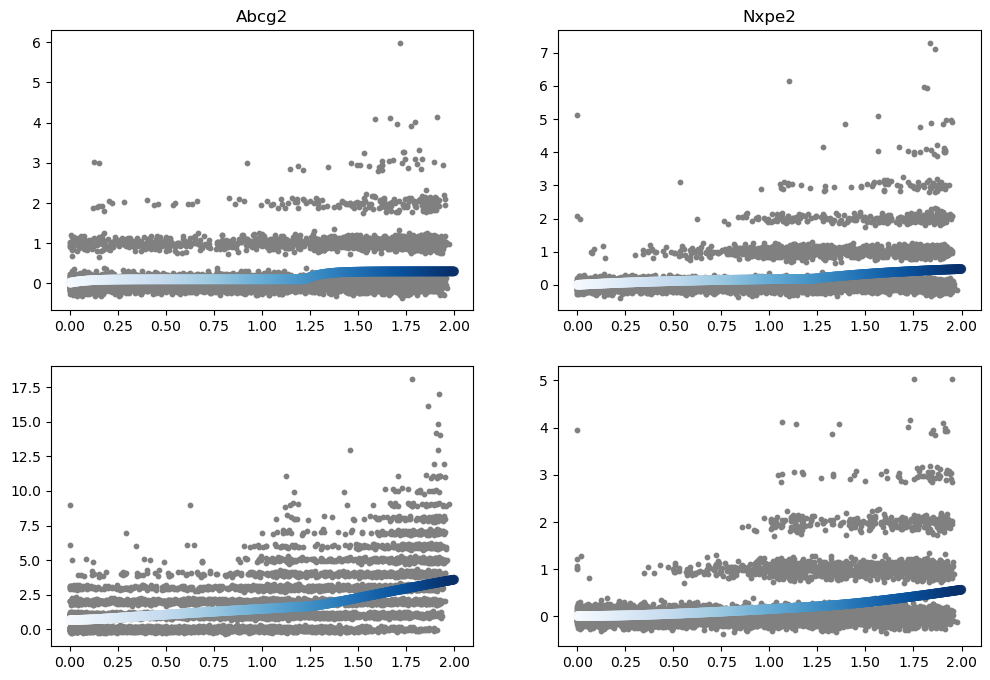

In [54]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

In [55]:
marker_genes = ['Gata1','Gata2','Hba-x']

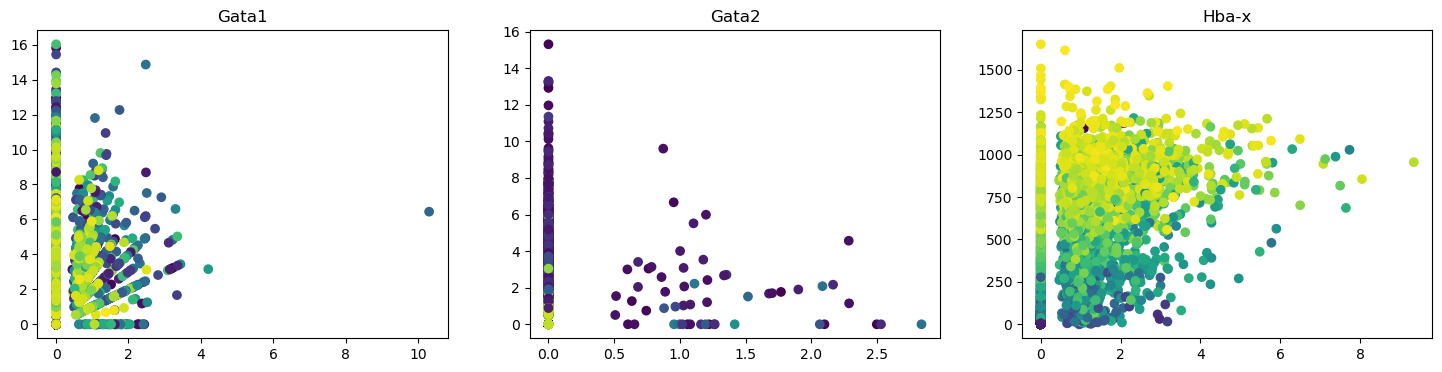

In [56]:
fig,ax = plt.subplots(1,len(marker_genes),figsize=(6*len(marker_genes),4))
for i,gene in enumerate(marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

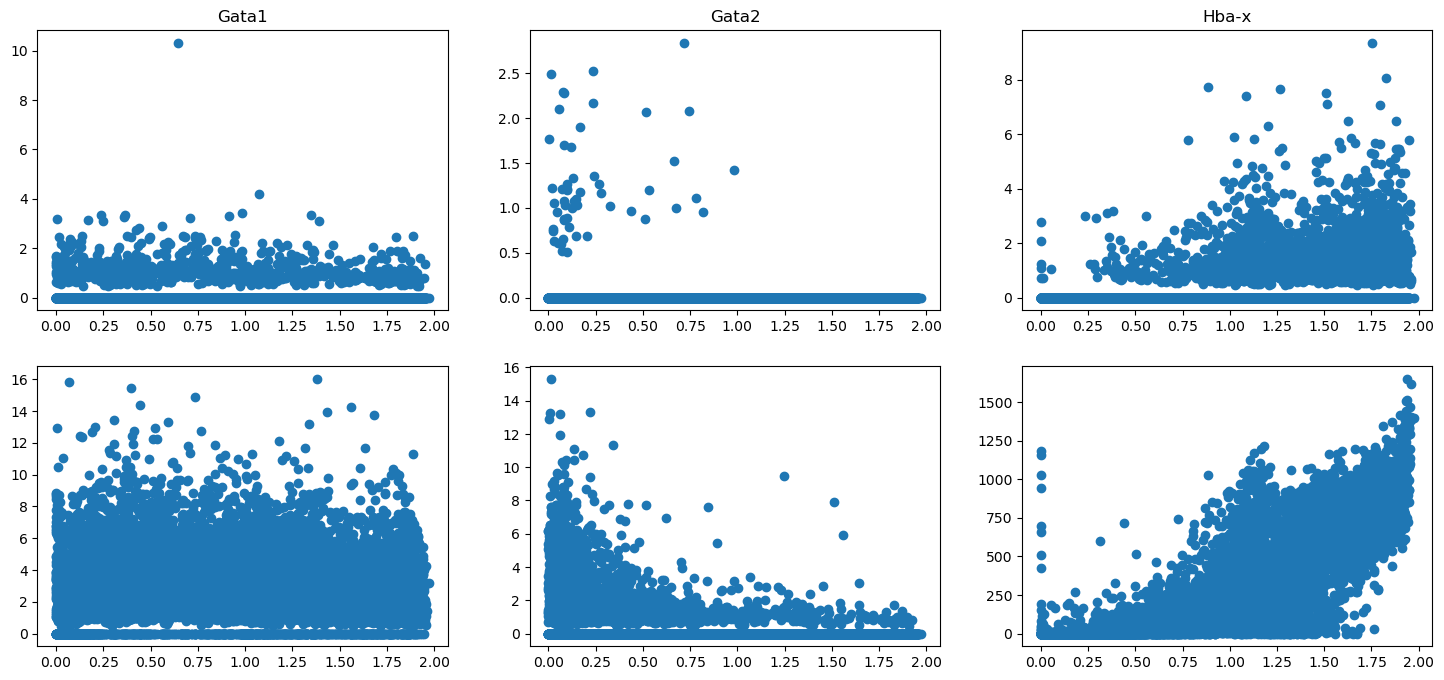

In [57]:
fig,ax = plt.subplots(2,len(marker_genes),figsize=(6*len(marker_genes),8))
for i,gene in enumerate(marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

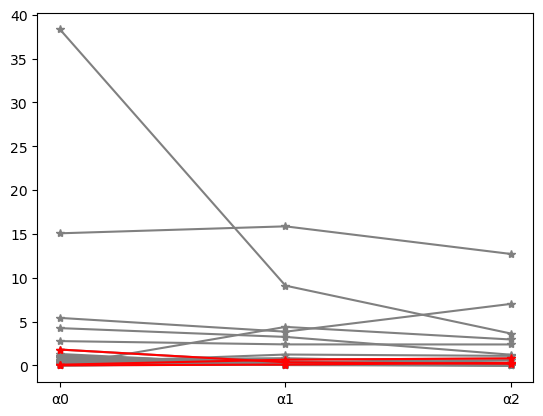

In [58]:
p = X.shape[1]
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [59]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

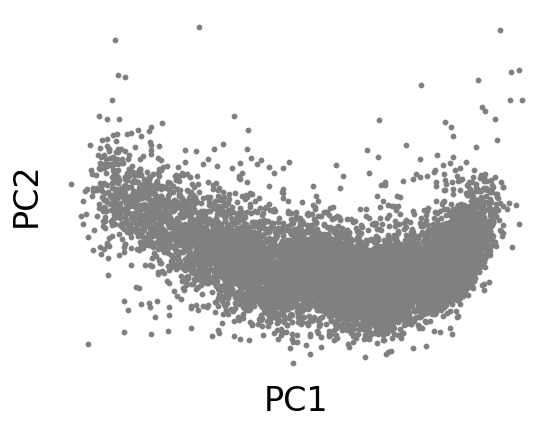

In [60]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [61]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(200):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [114]:
import pickle 

with open('results/Erythoid.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('results/Erythoid.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    trajs = pickle.load(f)

/tmp/ipykernel_3272105/1074205597.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')


Text(0.5, 1.0, 'Random initialiazation')

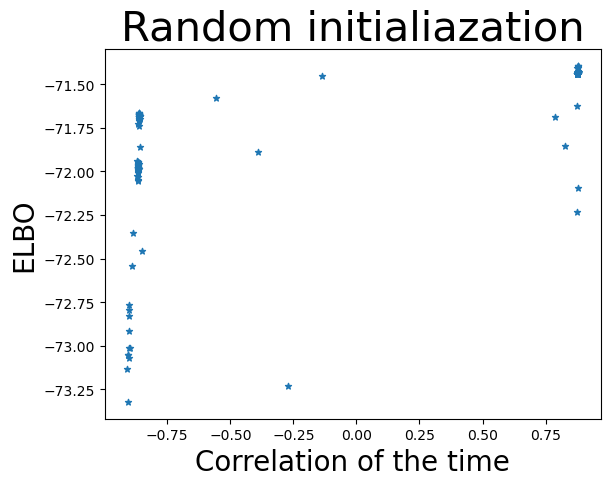

In [62]:
corrs = []
elbos = []
right_t = Q0[:,0] @ (np.linspace(0,2,m).reshape((-1,1)))
for traj in trajs:
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [105]:
traj = trajs[np.argmax(elbos)]
print(np.max(elbos),traj.compute_AIC(X_mix,standard=False),traj.compute_BIC(X_mix,standard=False))

-71.39439012949191 -71.40833785136401 -71.45760332660888


In [113]:
traj_tau = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_tau = traj_tau.fit(X,warm_start=True,params={'r':rd,"lambda_tau":0.01},Q=traj.Q.copy(),parallel=True,n_threads=4,epoch=10)
print(traj_tau.compute_AIC(X,standard=False))

fitting with warm start


100%|██████████| 10/10 [02:13<00:00, 13.33s/it]

-73.8033961225133


In [98]:
traj = traj_tau

[0.        1.2590963 2.       ]


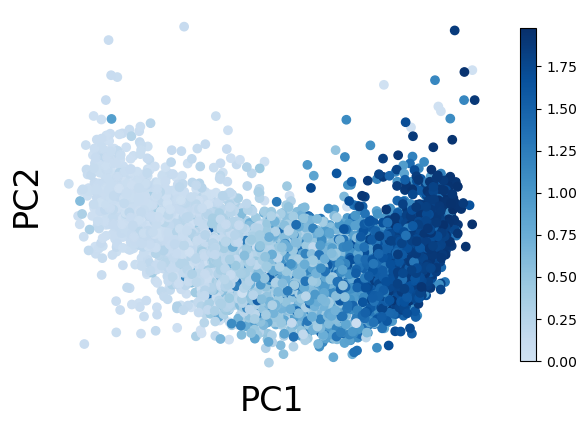

In [106]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

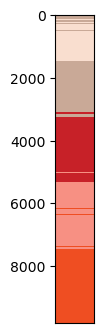

In [107]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,cell_type in enumerate(cell_types):
    idx = adata.obs["celltype"].isin([cell_type])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

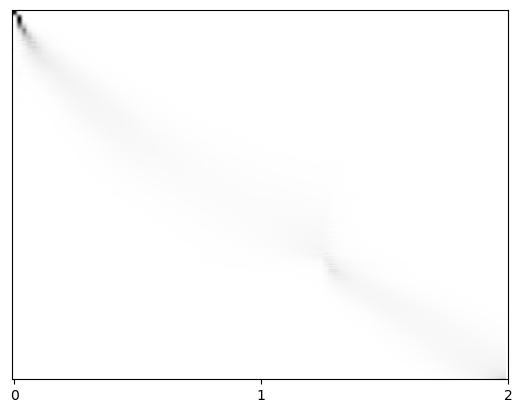

In [108]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

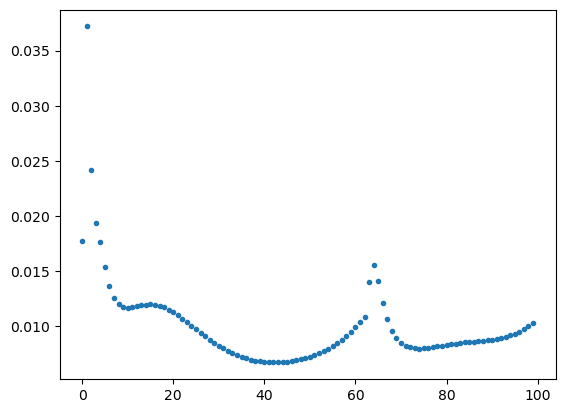

In [109]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

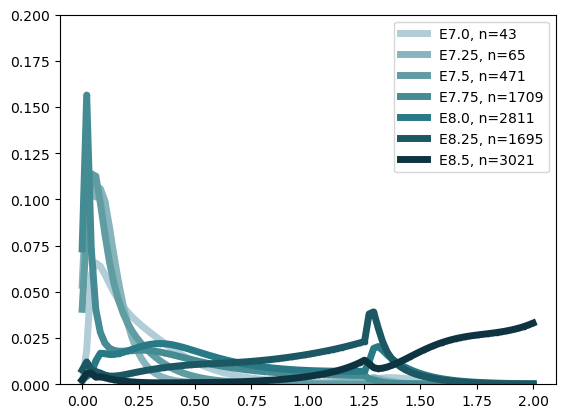

In [110]:
Timepoints = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']

#color_palette_blue = ["#b3cde0","#6497b1","#005b96","#011f4b"]
#color_palette = ["#daf8e3","#97ebdb","#00c2c7","#0086ad","#005582"]
#color_palette = ["#006666","#008080","#66b2b2","#b2d8d8"]
color_palette = ["#b1cdd8","#5f9da2","#2a7986","#0e3442"]

from matplotlib.colors import LinearSegmentedColormap
timepoint_cmp = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Timepoints))

for i,timepoint in enumerate(Timepoints):
    idx = adata.obs["stage"].isin([timepoint])
    plt.plot(traj.t,traj.Q[idx,0].mean(0),'.-',linewidth=5,label=timepoint+", n="+str(idx.sum()),color=timepoint_cmp(i))
plt.ylim((0,0.2))
plt.legend();

0.3170765392506155
0.15039231003076067
0.1572750224459392
0.34211240823520295
0.6984203221526358
0.9092346655911553
1.5350550951615767


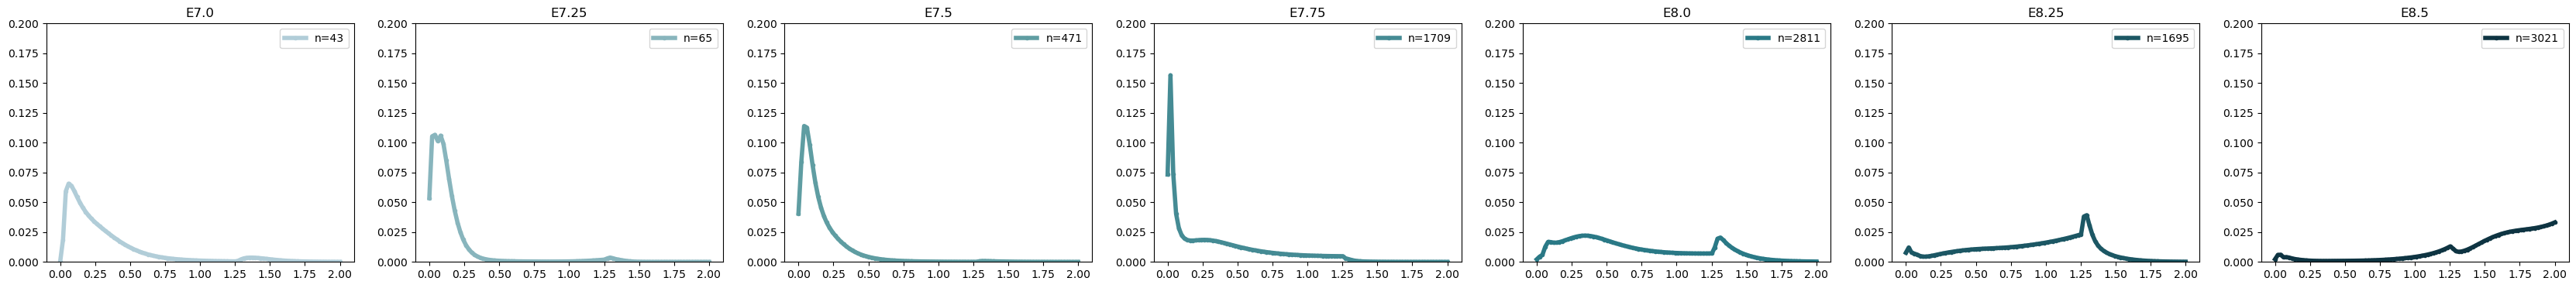

In [111]:
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']
fig, ax = plt.subplots(1,len(stages),figsize=(6*len(stages),4))
for i,stage in enumerate(stages):
    idx = adata.obs["stage"].isin([stage])
    ax[i].plot(traj.t,traj.Q[idx,0].mean(0),'.-',linewidth=4,label="n="+str(idx.sum()),color=timepoint_cmp(i))
    ax[i].set_title(stage)
    ax[i].set_ylim((0,0.2))
    ax[i].legend()
    print((traj.Q[idx,0].mean(0)@traj.t).mean())

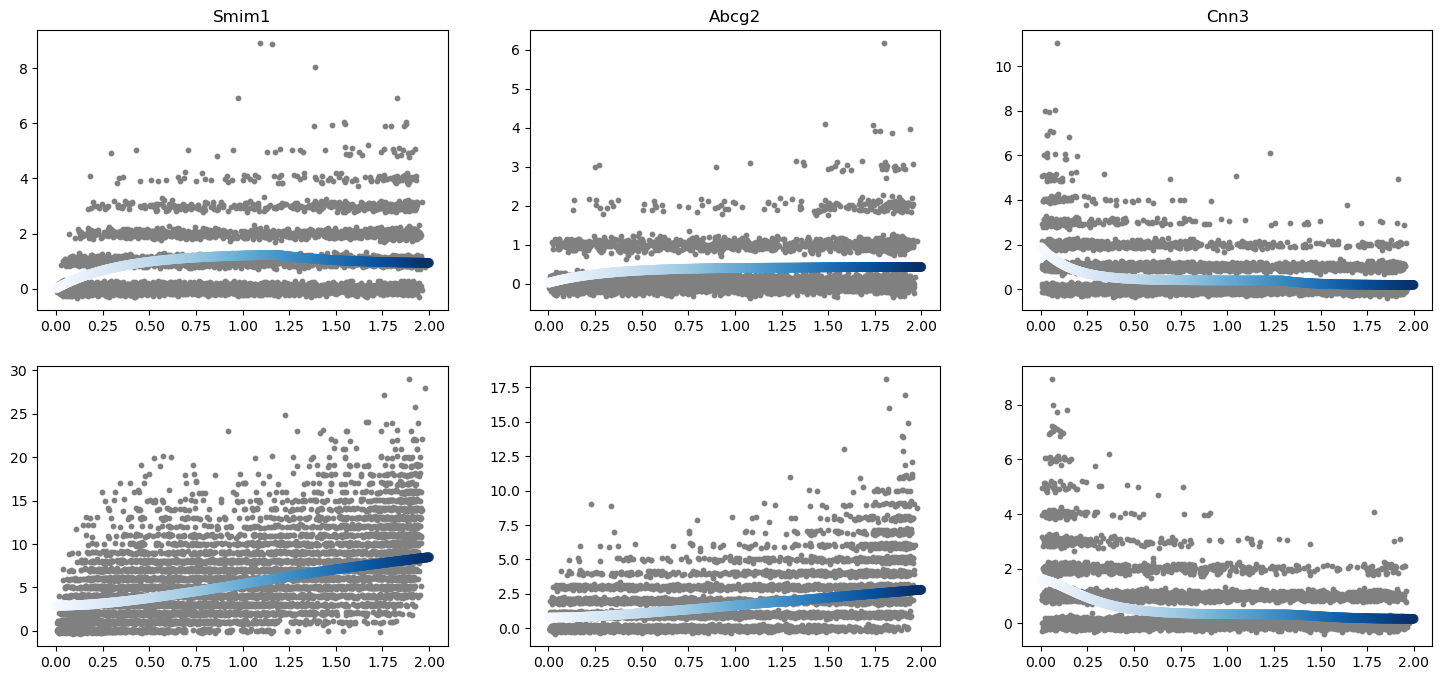

In [94]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

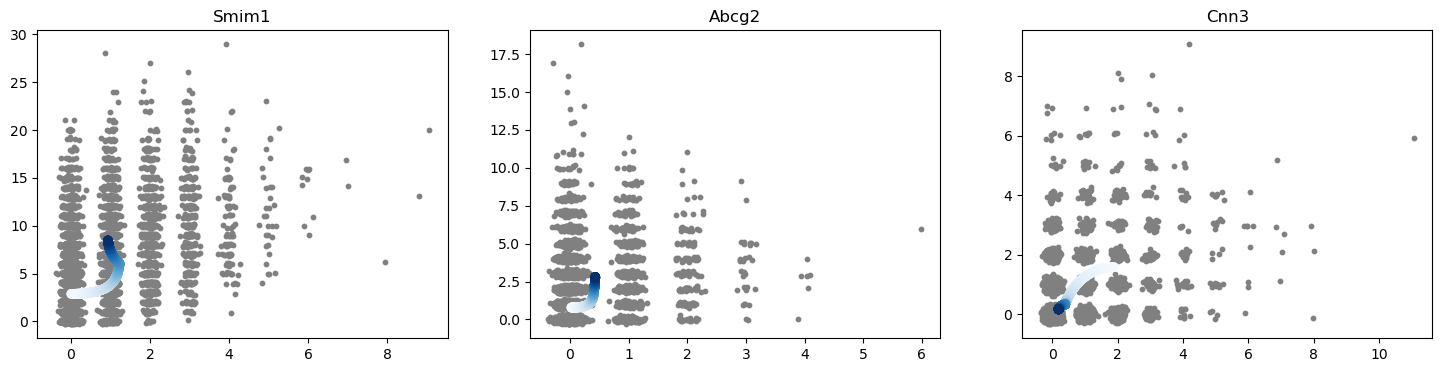

In [95]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

1


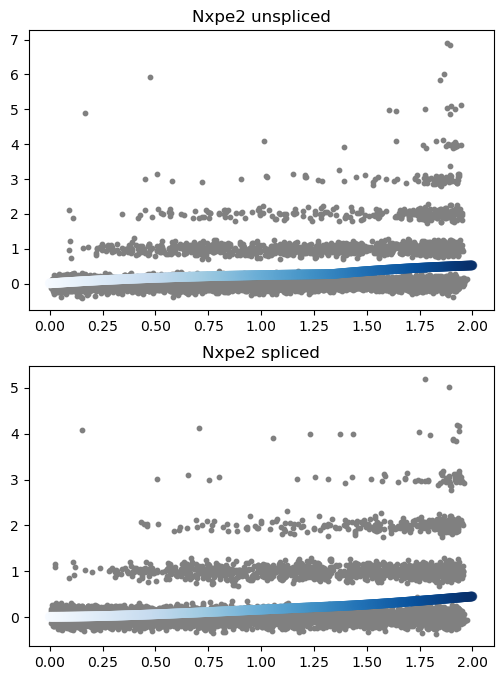

In [96]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

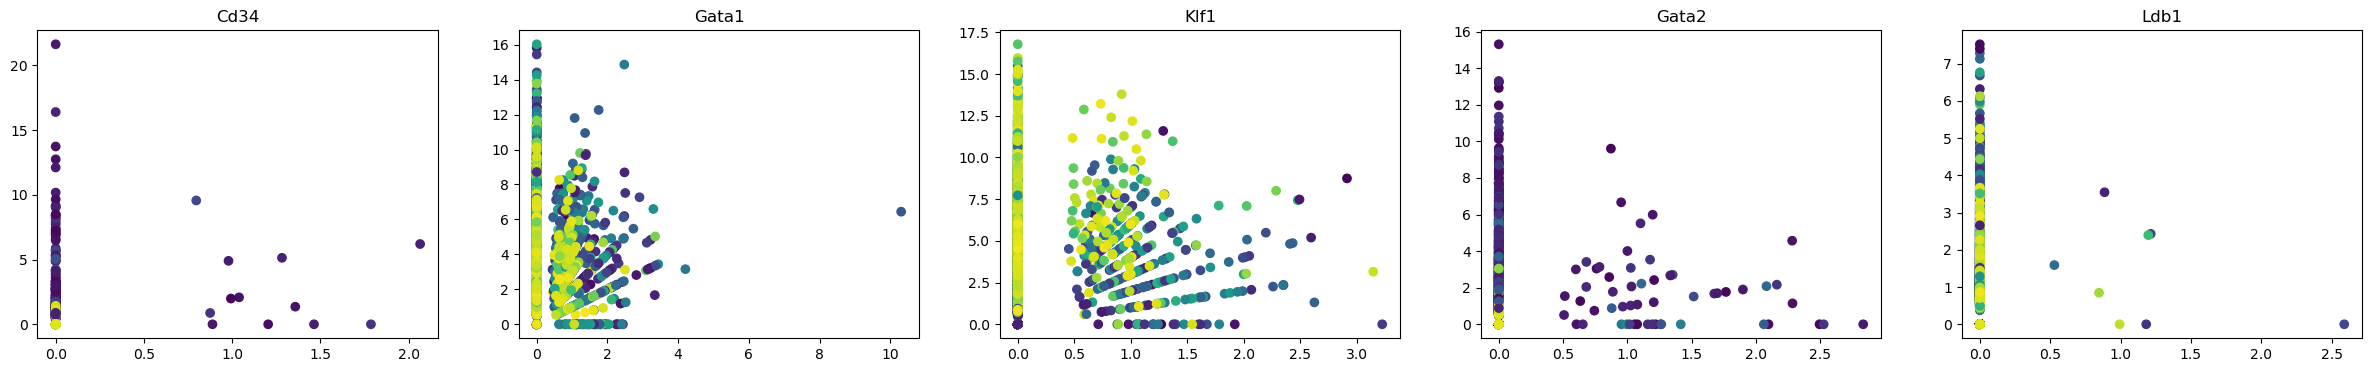

In [77]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

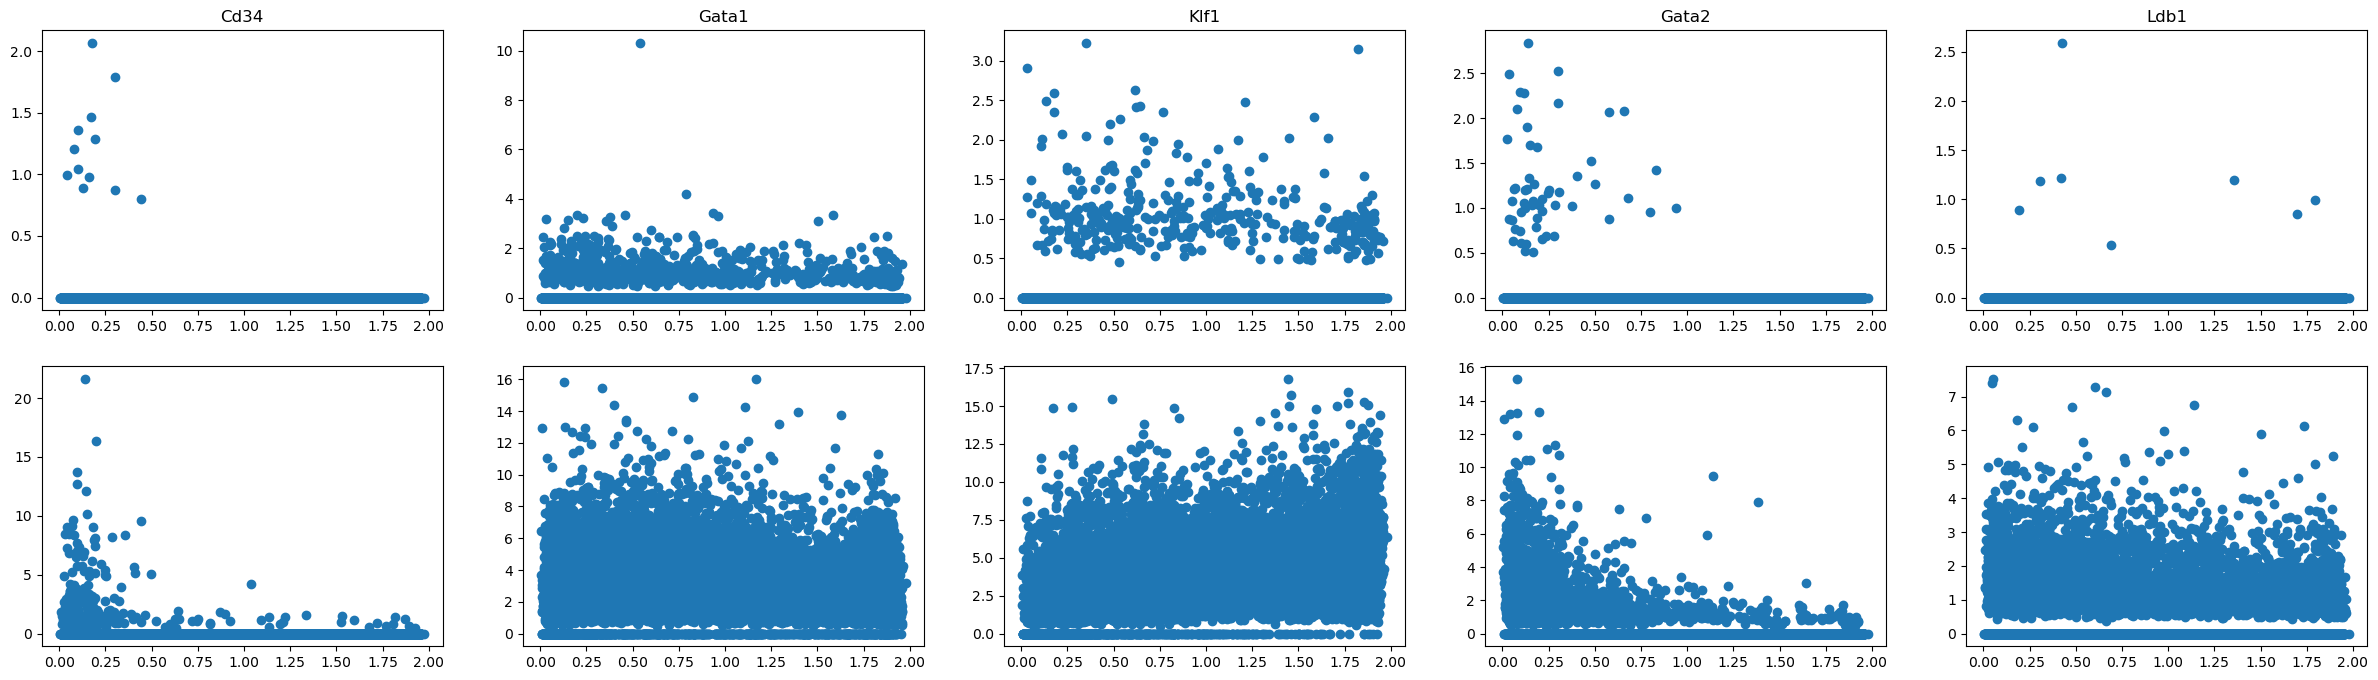

In [78]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

# Synthetic data

In [79]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=10,epoch=100)

fitting with warm start


 30%|███       | 30/100 [15:04<36:00, 30.87s/it]Process ForkPoolWorker-1551:
Exception ignored in: <function _releaseLock at 0x7f0a8c6ae8b0>
Traceback (most recent call last):
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Traceback (most recent call last):
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/conne

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mffang/miniconda3/envs/python_3.8/lib/pyt

In [ ]:
print(traj.elbos[-1])

In [ ]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [ ]:
plot_t(traj,order_cells=True)

In [ ]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

In [ ]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

In [ ]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(syn_X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),syn_X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [ ]:
U_mean = syn_X[:,:,0].mean(0)
U_var = syn_X[:,:,0].var(0)
S_mean = syn_X[:,:,1].mean(0)
S_var = syn_X[:,:,1].var(0)
ss = rd.var()

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + ss, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='k',alpha=1, s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + ss, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='k',alpha=1, s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [ ]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])

Input_args = []
def fit_wrapper(seed):
    syn_traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    syn_traj = syn_traj.fit(syn_X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return syn_traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    syn_trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [ ]:
corrs = []
elbos = []
for syn_traj in syn_trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append(syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)